# **Network Robustness**

In [1]:
#General Imports
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import matplotlib
from keras.datasets import cifar10
from keras import backend as K

#All Imports for Tensorflow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Importing the pretrained LeNet network
from networks.lenet import LeNet

# Helper functions
from differential_evolution import differential_evolution
import helper #These are some helper functions from one of the sources we cite at the beginning

# If running in Google Colab, import files
try:
    import google.colab
    in_colab = True
except:
    in_colab = False

if in_colab:
    !git clone https://github.com/Hyperparticle/one-pixel-attack-keras.git
    !mv -v one-pixel-attack-keras/* .
    !rm -rf one-pixel-attack-keras

Cloning into 'one-pixel-attack-keras'...
remote: Enumerating objects: 356, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 356 (delta 3), reused 1 (delta 0), pack-reused 346
Receiving objects: 100% (356/356), 44.57 MiB | 31.26 MiB/s, done.
Resolving deltas: 100% (204/204), done.
renamed 'one-pixel-attack-keras/1_one-pixel-attack-cifar10.ipynb' -> './1_one-pixel-attack-cifar10.ipynb'
renamed 'one-pixel-attack-keras/2_one-pixel-attack-imagenet.ipynb' -> './2_one-pixel-attack-imagenet.ipynb'
renamed 'one-pixel-attack-keras/attack.py' -> './attack.py'
renamed 'one-pixel-attack-keras/CONTRIBUTING.md' -> './CONTRIBUTING.md'
mv: cannot move 'one-pixel-attack-keras/data' to './data': Directory not empty
renamed 'one-pixel-attack-keras/differential_evolution.py' -> './differential_evolution.py'
renamed 'one-pixel-attack-keras/helper.py' -> './helper.py'
mv: cannot move 'one-pixel-attack-keras/images' to './images': Directory not

## **Summary:**


### **Terminology that we use throughout this section:**
-An "Adversarial Attack" refers to when an input image is changed in a small way (usually even hard to detect with the human eye) but it has a large effect on how a trained neural network processes and classifies the image

-A "Targeted Attack" refers to an adversarial attack where the image is changed in such a way that the network is most likely to classify one specific object as another specific object.  An example would an adversarial attack where all "guns" are now classified as "toothbrushes".  With an example like this it is easy to see relevance of these types of attacks in fields like TSA screening where correct object detection is vital.  

-A "Non-Targeted Attack" revers to an adversarial attack where the image is changed in such a way that the network misclassifies a certain kind of object (but it can classify it as anything else besides what it actually is).  An example of this kind of adversarial attack would be where all "guns" could now be classified as any other object like a "doll" or "hat" or "toothbrush" or "laptop" as long as it isn't a "gun"

-"Network Robustness" refers to how resistant a neural network is to adversarial examples that can be made on purpose to make the network misclassify objects

### **The General Algorithm that we Follow to Make more Robust Networks**
-The general algorithm for how we have been making our network models consistently more robust over time is that we have to Train our Network --> Find new adversarial examples (via solving optimization problems which can be computationally expensive, or via fast gradient sign method) --> retrain our network with these new adversarial examples in the training set --> repeat!

-This is a constantly developing field where people are constantly going back and forth creating new adversarial attacks while other solve them, and ultimately it is by this process that our network models become more robust.


### **Why do we care about network robustness and adversarial attacks?:**
-Last week we discussed how we could use model distillation in order to get lightweight models that could run in a realistic amount of time to be used in production while maintaining a high level of accuracy/performance.

-This week we will be discussing another very important part of any production model which is security and robustness of the model.  This matters because in real-world production there will most likely be people who will want to make malicious attacks on software products in order to make them behave in a different way that benefits them.  We need to make our models and networks as robust as possible so that these kinds of adversarial attacks don't work very well (in the example above we would want our TSA screening software to be robust to an attack so that the gun would be properly identified and confiscated at security)

### **Papers and Sources Cited that Helped with Ideas and Implementations:**
https://medium.com/@ml.at.berkeley/tricking-neural-networks-create-your-own-adversarial-examples-a61eb7620fd8

https://arxiv.org/abs/1710.08864

https://www.pyimagesearch.com/2020/10/19/adversarial-images-and-attacks-with-keras-and-tensorflow/

https://www.tensorflow.org/tutorials/generative/adversarial_fgsm

https://github.com/Hyperparticle/one-pixel-attack-keras

## **Part 1: Generating an Adversarial Example Using Fast Gradient Sign Method**

-In this section we use a single image from the imagenet dataset, and we show how we can use the fast gradient sign method to quickly generate an adversarial example for it!  We are also using the MobileNetV2 model which is a famous network model and it has been pretrained on the imagenet dataset.  Essentially we will be seeing how we can make a small perturbation to our sample image in order to confuse the MobileNetV2 model which has gone through extensive pretraining on the imagenet dataset!

-It is also important to note that since this is our first time using the imagenet dataset we have learned that it is trickier to use than the Cifar10 dataset and the MNIST dataset since it is so large (approximately 150 GB) making it impossible to download the whole thing onto our local machines like the others.  This is why we are simply pulling a single image example by the URL.

In [2]:
#Loading in the weights for the MobileNetV2 network which has already been trained on the 'imagenet' dataset
pretrainedMobileModel = tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet')
pretrainedMobileModel.trainable = False
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions #getting predictions from imagenet

In the cell below we import a single image of a yellow lab dog from imagenet by URL.  We then process the image to ensure it has the right dimensions for the input the mobilenet_v2 needs.  

In [3]:
#Loading in image via URL
image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)
image = tf.cast(image, tf.float32)
image = tf.image.resize(image, (224, 224))   #Resizing the image to be 224x224 so that it fits the input that mobilenet_v2 has been trained on
image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
image = image[None, ...]

# Helper function to extract labels from probability vector
def imageNetLabels(probs):
  return decode_predictions(probs, top=1)[0][0]
image_probs = pretrainedMobileModel.predict(image)

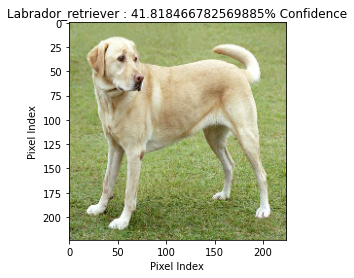

In [4]:
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)  #multiplying by 0.5 and adding 0.5 to shift the range of values from [-1,1] to [0,1]
_, image_class, class_confidence = imageNetLabels(image_probs)
plt.title(f"{image_class} : {class_confidence*100}% Confidence")
plt.xlabel("Pixel Index")
plt.ylabel("Pixel Index")
plt.show()

In the cell below we calculate the gradient of loss function with respect to the input image.  This gradient essentially tells us how we can change the input image in the way that will affect the neural network performance the most while minimizing how much we actually change the pixel values!  (This leads to the image looking basically the same to the naked eye, but the neural network performing terribly).  Thus this new altered image is an adversarial example!

In [5]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def adversarialGradientPattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrainedMobileModel(input_image)
    #print(prediction)
    loss = loss_object(input_label, prediction) #loss function we want to find the gradient of
    #print(loss)
  # Taking the gradient of the loss function with respect to the image
  gradient = tape.gradient(loss, input_image)
  signed_grad = tf.sign(gradient)   # Taking sign of gradient to make perturbation
  return signed_grad

Below I print out the label of the image that we are currently using.  We can see that its classification is index 208 "labrador_retriever" out of the possible 1000 classifications in the imagenet dataset.  We then take the gradient of this image that we are using and the brightly colored square below is the gradient image that will create the most change to how the mobilenet_v2 network will behaved when it is added/blended into the original image!

tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

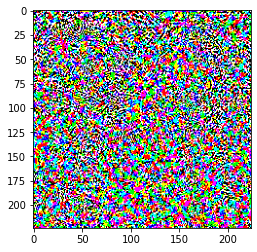

In [6]:
# Get the input label of the image.
currImageIndex = 208
label = tf.one_hot(currImageIndex, image_probs.shape[-1])
print(label)
label = tf.reshape(label, (1, image_probs.shape[-1]))
#print(label)
perturbations = adversarialGradientPattern(image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5); 

-In the cell below I create new input images for 7 different values of epsilon.  The higher the epsilon value, the more of the gradient function that I have added to the original image!  We can see that with the lower values of the epsilon that the image looks nearly the same (and is still very recognizable as a "labrador retriever" to us humans).  


-However even with epsilon=0.01 the pretrained mobilenet_v2 is already misclassifying it as a "Saluki" with 13% confidence!!!  We can see that as the epsilon value gets larger then the original image becomes more obscure and it isn't a very disguised attack anymore because we can plainly see the image has been altered!

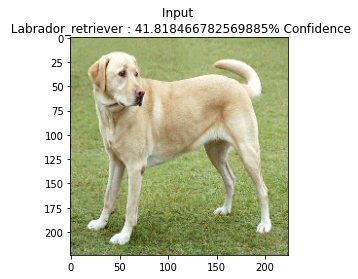

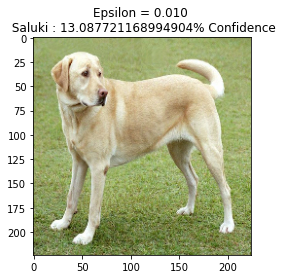

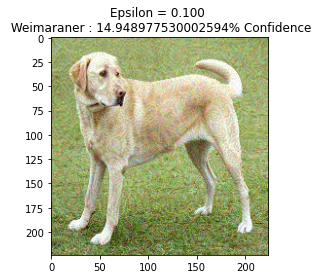

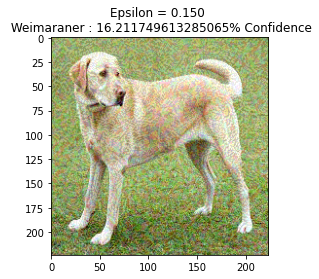

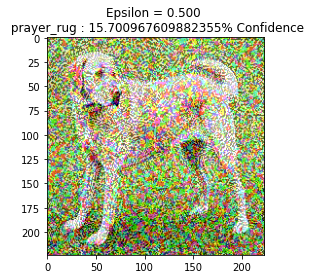

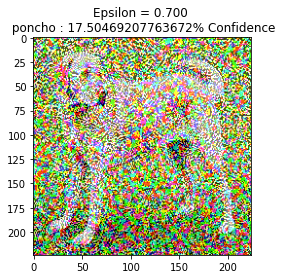

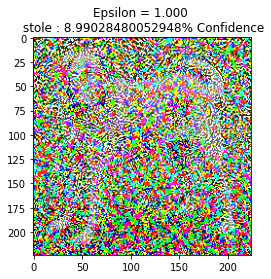

In [7]:
#This is a helper function which will plot the image and description passed into it!
def display_images(image, description):
  _, label, confidence = imageNetLabels(pretrainedMobileModel.predict(image)) #This is where we are predicting the label
                                                                              #for newly altered input images and giving
                                                                              #a confidence value for this label
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title(f"{description} \n {label} : {confidence*100}% Confidence")
  plt.show()
epsilons = [0, 0.01, 0.1, 0.15,0.5,0.7,1]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):      #Input the image value here as being the original plus some random amount of noise*epsilon value!
  adv_x = image + eps*perturbations #creating new input image where the gradient pattern is added to the original image!
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i])

## Part 2: One Pixel Attack Implementation with Cifar10
In this section we look at one pixel attacks where we are essentially creating adversarial examples by only changing the value of one specific pixel instead of taking the gradient of all the pixels!  This involves the L0 norm since we are only changing 1 (or in some cases a handful) of pixels.

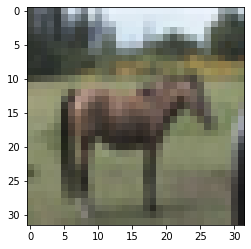

In [8]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.imshow(x_test[-1]) # Last image in test set because the first one was very blurry
plt.show()

In [9]:
#This function takes in the pixel info and the image that we are trying to update.  
#it changes the pixel at the input coordinates to the rgb values specified and returns the updated image
def alterSinglePixel(pixelInfo, img):
    # If just one pixel alteration is passed then put it into a list
    if pixelInfo.ndim < 2: #single pixel being altered
        pixelInfo = np.array([pixelInfo])
    tile = [len(pixelInfo)] + [1]*(pixelInfo.ndim+1)
    imgs = np.tile(img, tile)
    pixelInfo = pixelInfo.astype(int) #pixels rounded to ints
    
    for x,img in zip(pixelInfo, imgs):
        pixels = np.split(x, len(x) // 5)
        for pixel in pixels:
            x_pos, y_pos, *rgb = pixel #replace rgb values at coordinates specified
            img[x_pos, y_pos] = rgb
    return imgs

This cell below shows a demonstration of the "alterSinglePixel" function working where we change the center pixel of the horse to be red from its original color

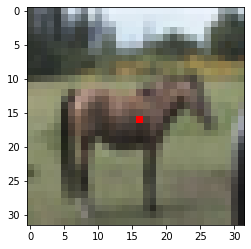

In [10]:
pixel = np.array([16, 16, 255, 0, 0]) # changing center pixel on the horse to be red pixel = x,y,r,g,b
image_perturbed = alterSinglePixel(pixel, x_test[-1])[0]
plt.imshow(image_perturbed)

Below we load in the pretrained LeNet() network model and we print out its accuracy as well as the number of parameters it has 

In [11]:
lenet = LeNet() #loading in the pretrained LeNet network model

models = [lenet]
network_stats, correct_imgs = helper.evaluate_models(models, x_test, y_test)
correct_imgs = pd.DataFrame(correct_imgs, columns=['name', 'img', 'label', 'confidence', 'pred'])
network_stats = pd.DataFrame(network_stats, columns=['name', 'accuracy', 'param_count'])
network_stats

Successfully loaded lenet
Evaluating lenet


,name,accuracy,param_count
0,lenet,0.7488,62006


In [12]:
#This function takes in the pixel information about the pixel it is altering, alters the image, and gets confidence predictions for the new image
#with the pretrained lenet model
def predict_classes(pixelInfo, img, desiredClass, model, minimize=True):
    imgs_perturbed = alterSinglePixel(pixelInfo, img)
    predictions = model.predict(imgs_perturbed)[:,desiredClass] #have the model make predictions for confidence levels with the new altered image
                                                                #that has been returned as the perturbed image
    return predictions if minimize else 1 - predictions

#This function returns whether the current pixel attack was successful or not.  It takes in whether it is a targetted attack or not
#if it is a targetted attack then it needs the confidence level for the desired classification to be high enough
#if it is a non-targetted attack then it just needs the misclassification rate to be high enough
def successfulAttack(x, img, desiredClass, model, targetedAttack=False, verbose=False):
    # Perturb the image with the given pixel(s) and get the prediction of the model
    attack_image = alterSinglePixel(x, img)
    confidence = model.predict(attack_image)[0]
    predicted_class = np.argmax(confidence)
    if verbose:
        print('Confidence:', confidence[desiredClass])
    if ((targetedAttack and predicted_class == desiredClass) or
        (not targetedAttack and predicted_class != desiredClass)):
        return True

Below we plot one of the suggested images from the resource we were following while implementing this single-pixel attack algorithm.  We can see how the prior confidence jumps all the way from 0.74 to 0.79 just by changing a single pixel to a certain color in the image which is amazing!  Note that we used the recommended image and pixel replacement value here, but below we can find our own "highly impactful" pixels by using a genetic algorithm in an "attack" to determine the best pixels to change and what to change them to! 

Confidence: 0.79345137
Prior confidence 0.7412686
Attack success: False


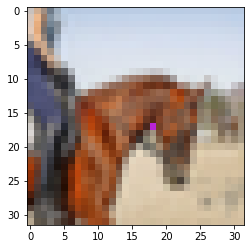

In [13]:
image_id = 541
pixel = np.array([17, 18, 185, 36, 215])
model = lenet

true_class = y_test[image_id, 0]
prior_confidence = model.predict_one(x_test[image_id])[true_class]
success = successfulAttack(pixel, x_test[image_id], true_class, model, verbose=True)

print('Prior confidence', prior_confidence)
print('Attack success:', success == True)
plt.imshow((alterSinglePixel(pixel, x_test[image_id])[0]))

In the following function we followed an online resource as well as the lecture slides on single pixel attacks to create a genetic algorithm to determine the best pixel to change and what to change it to.  This attack function also allows us to specify the number of pixels we want the algorithm to be able to change in order to create the most impactful "attack".  Note that the number of pixels relates to the d value in the L0 norm where if we have 1 pixel then d=1, if we are changing 2 pixels then d=2.

In [14]:
#This is the genetic algorithm that is covered in the slides and a resource we were using to 
#create several populations of "candidate solution pixels" in order to search for the best pixel to change
#in the given image and what to change it to to have the greatest effect on the network!
def attack(img_id, model, target=None, pixel_count=1, 
           maxiter=100, popsize=400, verbose=False):
    # Change the target class based on whether this is a targeted attack or not
    targetedAttack = target is not None
    desiredClass = target if targetedAttack else y_test[img_id, 0]
    
    # Define bounds for a flat vector of x,y,r,g,b values
    # For more pixels, repeat this layout
    bounds = [(0,32), (0,32), (0,256), (0,256), (0,256)] * pixel_count
    
    # Population multiplier, in terms of the size of the perturbation vector x
    popmul = max(1, popsize // len(bounds))
    
    # Format the predict/callback functions for the differential evolution algorithm
    def predict_fn(pixelInfo):
        return predict_classes(pixelInfo, x_test[img_id], desiredClass, 
                               model, target is None)
    
    def callback_fn(x, convergence):
        return successfulAttack(x, x_test[img_id], desiredClass, 
                              model, targetedAttack, verbose)
    
    # Call Scipy's Implementation of Differential Evolution
    attack_result = differential_evolution(
        predict_fn, bounds, maxiter=maxiter, popsize=popmul,
        recombination=1, atol=-1, callback=callback_fn, polish=False)

    # Calculate some useful statistics to return from this function
    attack_image = alterSinglePixel(attack_result.x, x_test[img_id])[0]
    prior_probs = model.predict_one(x_test[img_id])
    predicted_probs = model.predict_one(attack_image)
    predicted_class = np.argmax(predicted_probs)
    actual_class = y_test[img_id, 0]
    success = predicted_class != actual_class
    cdiff = prior_probs[actual_class] - predicted_probs[actual_class]

    # Show the best attempt at a solution (successful or not)
    helper.plot_image(attack_image, actual_class, class_names, predicted_class)

    return [model.name, pixel_count, img_id, actual_class, predicted_class, success, cdiff, prior_probs, predicted_probs, attack_result.x]

## Untargeted Attack:
In this section we perform an untargeted attack on an image in the cifar10 dataset that was recommended by the resource we were using.  We limit this attack to a single pixel attack. Here we can see that the single pixel untargeted attack failed because we weren't able to get the network to misclassify the frog enough here.

Confidence: 0.9670719
Confidence: 0.9668387
Confidence: 0.9544233
Confidence: 0.9543239
Confidence: 0.9506395
Confidence: 0.9422982
Confidence: 0.94112253
Confidence: 0.94112253
Confidence: 0.94112253
Confidence: 0.938686
Confidence: 0.938686
Confidence: 0.938686
Confidence: 0.938686
Confidence: 0.937743
Confidence: 0.937743
Confidence: 0.937743
Confidence: 0.937743
Confidence: 0.937743
Confidence: 0.937743
Confidence: 0.937743
Confidence: 0.9377285
Confidence: 0.9377285
Confidence: 0.9377285
Confidence: 0.9376082
Confidence: 0.9376082
Confidence: 0.93737924
Confidence: 0.93737924
Confidence: 0.93737924
Confidence: 0.93737924
Confidence: 0.93737924
Confidence: 0.93737924
Confidence: 0.93737924
Confidence: 0.93737924
Confidence: 0.93737924
Confidence: 0.93737924
Confidence: 0.93737924
Confidence: 0.93737924
Confidence: 0.93737215
Confidence: 0.93737215
Confidence: 0.93737215
Confidence: 0.93737215
Confidence: 0.93737215
Confidence: 0.93737215
Confidence: 0.93737215
Confidence: 0.9373721

/content/differential_evolution.py:585: RuntimeWarning: divide by zero encountered in double_scalars
  convergence=self.tol / convergence) is True):


Confidence: 0.93737215
Confidence: 0.93737215
Confidence: 0.93737215
Confidence: 0.93737215
Confidence: 0.93737215
Confidence: 0.93737215
Confidence: 0.93737215
Confidence: 0.93737215
Confidence: 0.93737215
Confidence: 0.93737215
Confidence: 0.93737215
Confidence: 0.93737215
Confidence: 0.93737215
Confidence: 0.93737215
Confidence: 0.93737215
Confidence: 0.93737215
Confidence: 0.93737215
Confidence: 0.93737215
Confidence: 0.93737215
Confidence: 0.93737215
Confidence: 0.93737215
Confidence: 0.93737215
Confidence: 0.93737215
Confidence: 0.93737215
Confidence: 0.93737215
Confidence: 0.93737215
Confidence: 0.93737215
Confidence: 0.93737215
Confidence: 0.93737215
Confidence: 0.93737215
Confidence: 0.93737215
Confidence: 0.93737215
Confidence: 0.93737215


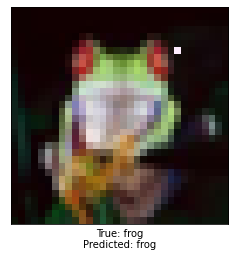

In [15]:
image_id = 102
pixels = 1 # Number of pixels to attack
model = lenet

_ = attack(image_id, model, pixel_count=pixels, verbose=True)

## Targeted Attack
In this short section we once again create an attack on a recommended image by the resource we were using.  We see that in this example we were creating an attack that makes the network think that the ship image is actually an automobile.  Here we are able to do this by only changing 5 pixels and we are able to make the network 49% confident that the image is an automobile (which is incorrect)!!

Attacking with target automobile
Confidence: 0.036093026
Confidence: 0.12602408
Confidence: 0.12602408
Confidence: 0.12602408
Confidence: 0.12602408
Confidence: 0.12602408
Confidence: 0.12602408
Confidence: 0.12602408
Confidence: 0.1886059
Confidence: 0.1886059
Confidence: 0.1886059
Confidence: 0.1886059
Confidence: 0.1886059
Confidence: 0.1886059
Confidence: 0.1886059
Confidence: 0.1886059
Confidence: 0.1886059
Confidence: 0.1886059
Confidence: 0.1886059
Confidence: 0.1886059
Confidence: 0.1886059
Confidence: 0.1886059
Confidence: 0.1886059
Confidence: 0.1886059
Confidence: 0.20898941
Confidence: 0.20898941
Confidence: 0.2312218
Confidence: 0.2312218
Confidence: 0.4783661
Confidence: 0.4783661
Confidence: 0.4783661
Confidence: 0.4783661
Confidence: 0.4783661
Confidence: 0.4783661
Confidence: 0.4783661
Confidence: 0.49494576


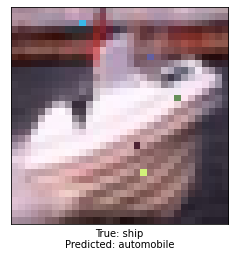

In [16]:
image_id = 108
desiredClass = 1 # Integer in range 0-9
pixels = 5
model = lenet

print('Attacking with target', class_names[desiredClass])
_ = attack(image_id, model, desiredClass, pixel_count=pixels, verbose=True)

## **Part 3: Network Comparisons of Robustness Against one Pixel Attack**
Due to time constraints we were unable to get to this part, but we wanted to include a quick jist so we could get some advice on whether it is something worthwhile to pursue in a future report!  In this section we were planning on using several pretrained networks (possibly our own networks like the distillation network we created last week) and comparing how they hold up against identically ran single pixel attacks to see which networks are the most robust without any modification.  Thank you for your time, help, and advice!